<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/AFRL/AFRL_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

###Step 1: Plot the original Data

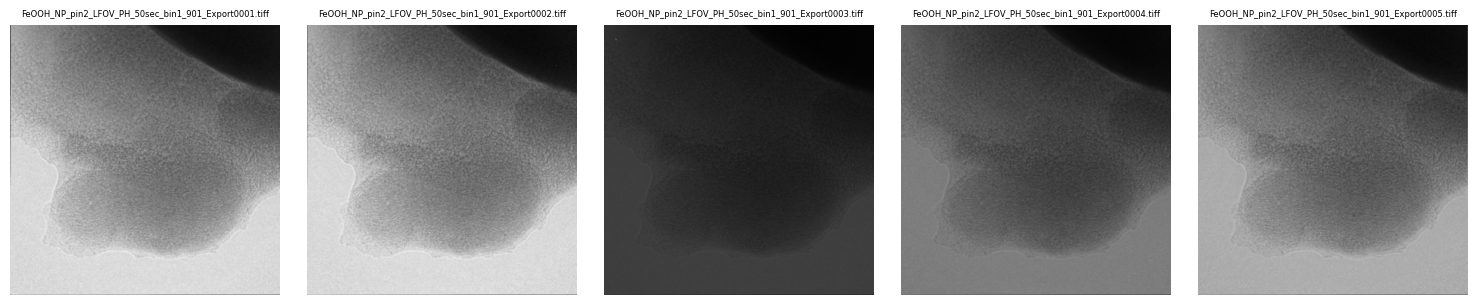

In [70]:
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt

# Path to TIFF folder
folder_path = '/content/drive/MyDrive/AFRL/raw_tiff_PH_pin2'

# Get and sort TIFF files
files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tiff')])

# Plot the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    img = iio.imread(os.path.join(folder_path, files[i]))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(files[i], fontsize=6)

plt.tight_layout()
plt.show()


###Step 2: Create the Data

In [21]:
#inititlize dimension
NumViews = 900         # Number of TIFF files
NumChannels = 1024     # Width of each TIFF image
NumSlices = 1024       # Number of rows (slices)

#Create empty 3D space to store data
data = np.zeros((NumSlices, NumChannels, NumViews), dtype=np.float32)


#Build a 3D data where 1st dimension is slice, 2nd dimension id channel, 3rd dimension is views
for iv in range(1, NumViews + 1):  # Loop over all views to store in the data
    file_path = os.path.join(
        folder_path, f'FeOOH_NP_pin2_LFOV_PH_50sec_bin1_901_Export0{iv:03d}.tiff'
    )
    img = iio.imread(file_path).astype(np.float32)
    data[:, :, iv - 1] = img

###Plot Data

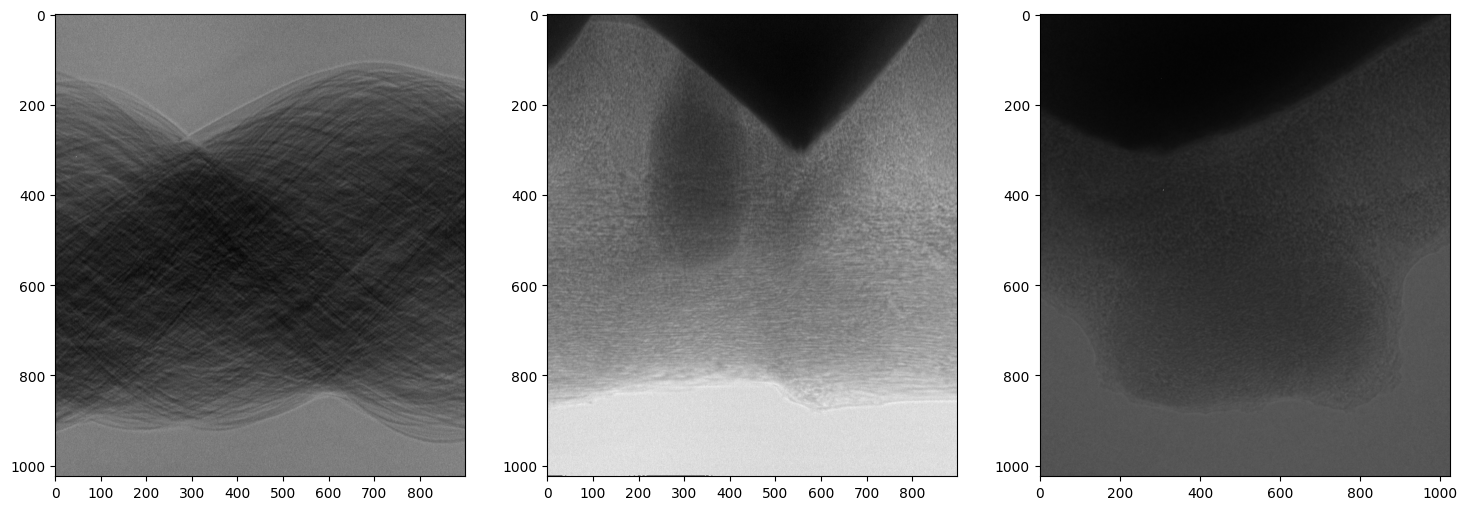

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(data[700, :, :], cmap='gray', aspect='auto')
axs[1].imshow(data[:, 700, :], cmap='gray', aspect='auto')
axs[2].imshow(data[:, :, 700], cmap='gray', aspect='auto')

plt.show()

###Step 3: Normalize the data(light scan correction)


In [23]:
ref_image_path = os.path.join(folder_path, '/content/drive/MyDrive/AFRL/raw_tiff_PH_pin2/FeOOH_NP_pin2_LFOV_PH_50sec_bin1_901_Export0501.tiff')
cropped_dataset = iio.imread(ref_image_path)
cropped_dataset = cropped_dataset[900:1001, :]  # Use rows 900–1000 to compute mean
maximumNumber = float(np.mean(cropped_dataset))  #  Mean value used to normalize all TIFFs
del cropped_dataset  # Free up memory
data_norm = np.zeros((NumSlices, NumChannels, NumViews), dtype=np.float32)

for iv in range(1, NumViews + 1):
    data_norm[:, :, iv - 1] = data[:, :, iv - 1] / maximumNumber  #Normalize each TIFF image

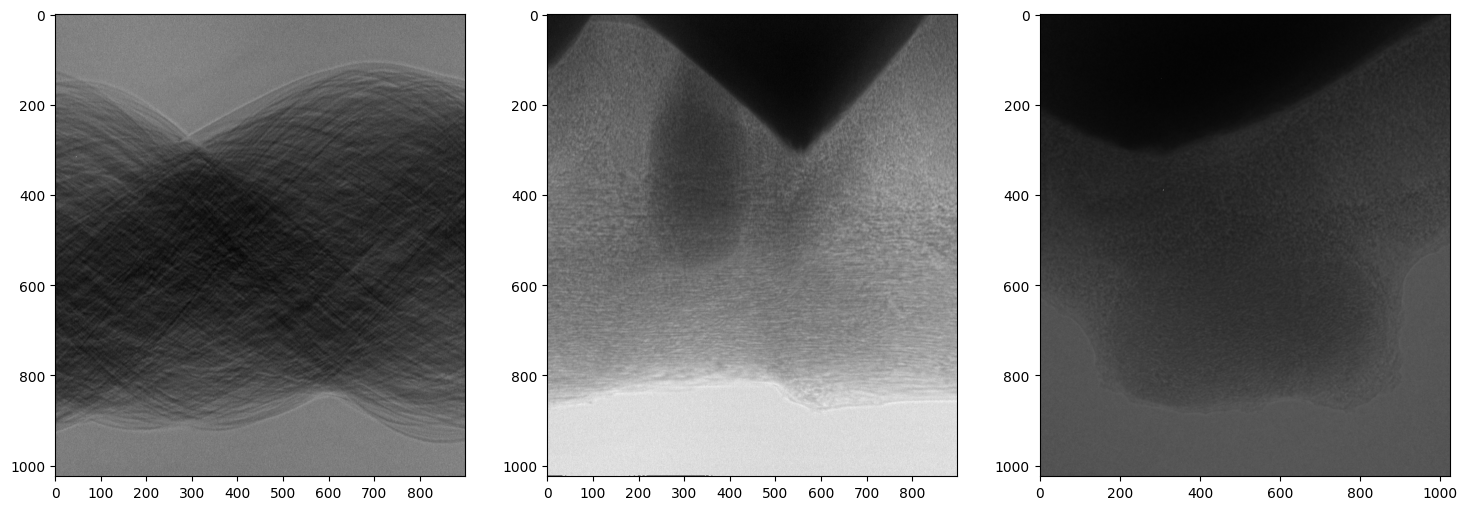

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(data_norm[700, :, :], cmap='gray', aspect='auto')
axs[1].imshow(data_norm[:, 700, :], cmap='gray', aspect='auto')
axs[2].imshow(data_norm[:, :, 700], cmap='gray', aspect='auto')

plt.show()

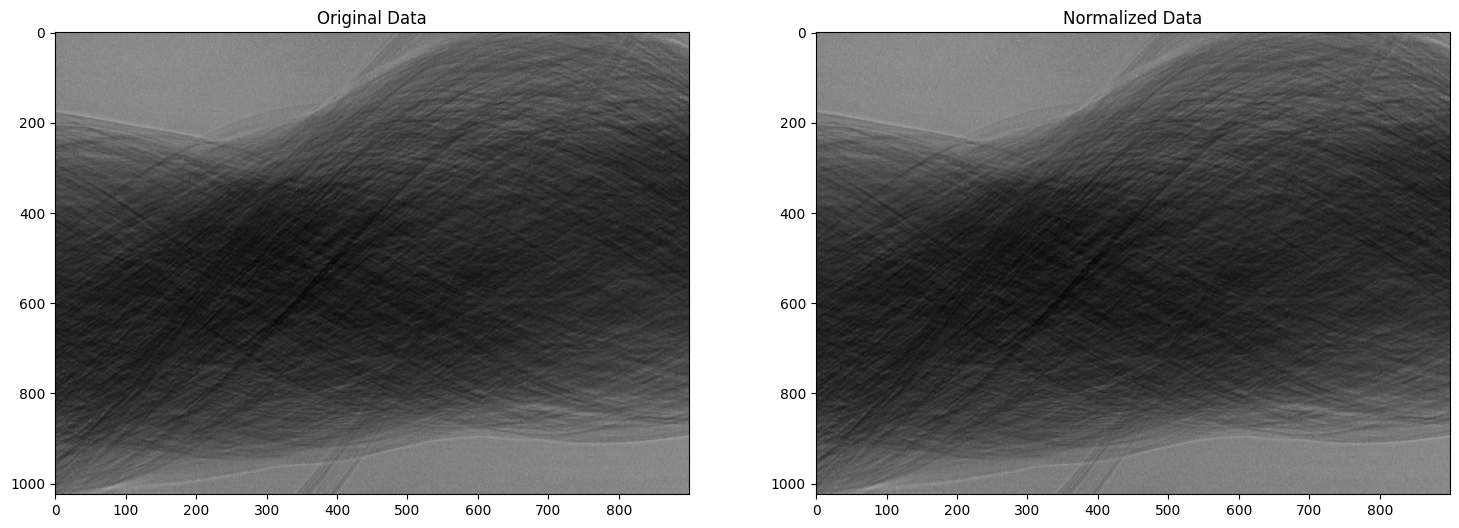

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(data[600, :, :], cmap='gray', aspect='auto')
axs[0].title.set_text('Original Data')
axs[1].imshow(data_norm[600, :, :], cmap='gray', aspect='auto')
axs[1].title.set_text('Normalized Data')
plt.show()


###Step 3: Create Sino & wght files

In [31]:
output_dir = '/content/drive/MyDrive/AFRL_Preprocessing'
output_basename = 'slice'
for i in range(NumSlices):  # Loop over each slice (row)
    basename = os.path.join(output_dir, output_basename)

    # Create and save .sino file (log-transformed sinogram)
    sino = -np.log(data_norm[i, :, :])  # Apply negative log to normalized data
    sino_filename = f"{basename}{i+1:04d}.sino"
    sino.astype('float32').tofile(sino_filename) #.tofile is saving the file with the sino_filename


Create wght files

In [32]:
for i in range(NumSlices):  # Loop over each slice (row)
    basename = os.path.join(output_dir, output_basename)

    #Create and save .wght file (weights based on noise variance)
    variance_of_noise = np.var(sino)
    weight = data_norm[i, :, :] / variance_of_noise
    weight_filename = f"{basename}{i+1:04d}.wght"
    weight.astype('float32').tofile(weight_filename) ##.tofile is saving the file with the weight filename

Check the sino and wght files

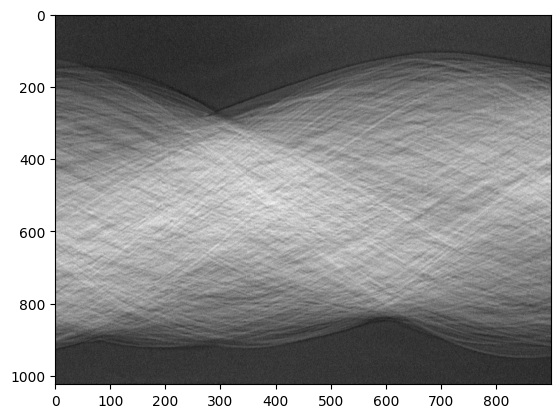

In [36]:
# Path
sino_file = '/content/drive/MyDrive/AFRL_V2/slice0700.sino'

# dimension setup
channels = 1024
views = 900

# reshaping 1D to 2D
sino = np.fromfile(sino_file, dtype='float32').reshape((channels, views))

plt.imshow(sino, cmap='gray', aspect='auto')
plt.show()


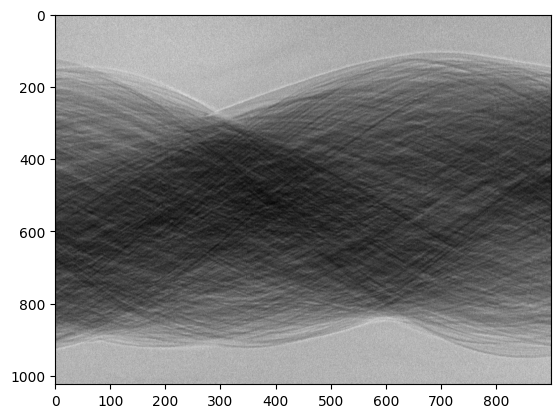

In [38]:
# Path
wght_file = '/content/drive/MyDrive/AFRL_V2/slice0700.wght'

# dimension setup
channels = 1024
views = 900

# reshaping 1D to 2D
wght = np.fromfile(wght_file, dtype='float32').reshape((channels, views))

plt.imshow(wght, cmap='gray', aspect='auto')
plt.show()


### Step 4: FBP with iradon

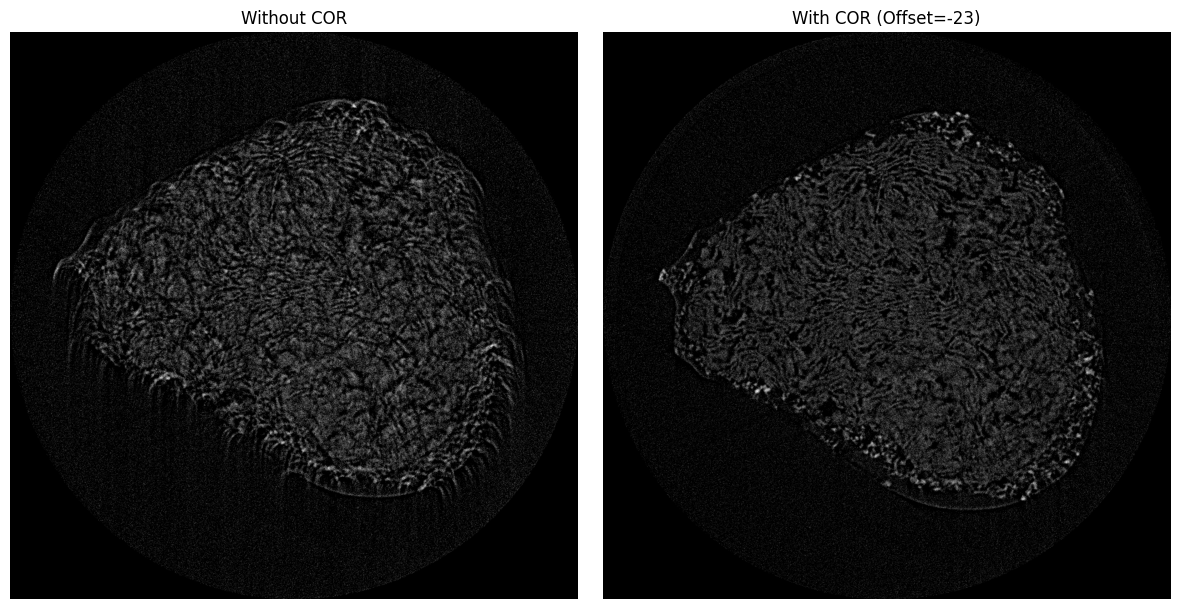

In [69]:
from skimage.transform import iradon

# Settings
slice_id = 700
file = f'/content/drive/MyDrive/AFRL_Preprocessing/slice{slice_id:04d}.sino'
offset = -23  # COR offset

# Load sinogram and projection angles
sino = np.fromfile(file, np.float32).reshape((1024, 900)) # reshape 1D numpy to 2D numpy(1024 is detector channel or rows and 900 is views)
theta = np.linspace(0, 180, 900, endpoint=False)

# Apply COR correction
sino_cor = np.roll(sino, offset, axis=0) # axis = 0 works perfectly to reduce the artifact

# Reconstruct images
recon1 = iradon(sino, theta, filter_name='ramp', interpolation='linear', circle=True, output_size=1024)
recon2 = iradon(sino_cor, theta, filter_name='ramp', interpolation='linear', circle=True, output_size=1024)

# Normalize for display (without normalize the image looks washed out)
def normalize(img):
    img[img < 0] = 0
    return (img / np.max(img) * 255).astype(np.uint8)

recon1 = normalize(recon1)
recon2 = normalize(recon2)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(recon1, cmap='gray')
plt.title('Without COR')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon2, cmap='gray')
plt.title(f'With COR (Offset={offset})')
plt.axis('off')

plt.tight_layout()
plt.show()
